# Import Libraries

In [56]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Configurations

In [57]:
# Setup the paths to train and test images
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMG_SIZE = 256
BATCH_SIZE = 32

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Data Loading

In [58]:
df = pd.read_csv('./df_augment copy.csv')
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338915 entries, 0 to 338914
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  338915 non-null  object 
 1   x         338915 non-null  float64
 2   y         338915 non-null  float64
 3   w         338915 non-null  float64
 4   h         338915 non-null  float64
 5   source    338915 non-null  object 
dtypes: float64(4), object(2)
memory usage: 15.5+ MB


In [59]:
# Function to group bounding boxes
def group_bounding_boxes(group):
    bboxes = np.array(list(zip(group['x'], group['y'], group['w'], group['h'])), dtype=np.float32)
    return pd.Series([bboxes], index=['bboxes'])

# Group by image ID and apply the group_bounding_boxes function
df = df.groupby('image_id').apply(group_bounding_boxes).reset_index()

# Save the grouped DataFrame to a new CSV file
# grouped_df.to_csv('./df_grouped.csv', index=False)

C:\Users\WenShen\AppData\Local\Temp\ipykernel_24020\1882872937.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('image_id').apply(group_bounding_boxes).reset_index()


In [60]:
max_bboxes = max(df['bboxes'].apply(len))
print(f"Maximum number of bounding boxes in the dataset: {max_bboxes}")

def load_image_and_bbox(image_id, bboxes, max_bboxes=max_bboxes):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    image = image / 255.0
    
    # Adjust bounding boxes
    scale = tf.cast(original_size[0], tf.float32) / IMG_SIZE
    bboxes = bboxes / scale
    return image, bboxes

def parse_dataframe(df, TRAIN_DIR=TRAIN_DIR, AUG_SAVE_DIR=AUG_SAVE_DIR):
    image_ids = []
    all_bboxes = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Parsing dataframe and image path'):
        image_id = row['image_id']
        ori_image_path = f'{TRAIN_DIR}/{image_id}.jpg'
        augmented_image_path = f'{AUG_SAVE_DIR}/{image_id}.jpg'
        if os.path.exists(ori_image_path):
            image_path = ori_image_path
        else:
            image_path = augmented_image_path
        image_ids.append(image_path)
        bboxes = row['bboxes']
        bboxes = tf.pad(bboxes, [[0, max_bboxes - tf.shape(bboxes)[0]], [0, 0]])
        all_bboxes.append(bboxes)
    return image_ids, all_bboxes

def create_dataset(image_paths, bboxes, batch_size=BATCH_SIZE):
    # def generator():
    #     for img_path, bbox in zip(image_paths, bboxes):
    #         yield img_path, bbox
    
    # dataset = tf.data.Dataset.from_generator(
    #     generator,
    #     output_signature=(
    #         tf.TensorSpec(shape=(), dtype=tf.string),
    #         tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    #     )
    # )
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes))
    dataset = dataset.map(lambda x, y: load_image_and_bbox(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

image_ids, bboxes = parse_dataframe(df)


Maximum number of bounding boxes in the dataset: 116


Parsing dataframe and image path: 100%|██████████| 10120/10120 [00:10<00:00, 970.95it/s]


In [61]:
# Define the random transformation function
def random_transform(image, bbox):
    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Randomly adjust saturation
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    
    # Randomly adjust hue
    image = tf.image.random_hue(image, max_delta=0.1)
    
    return image, bbox

# Split the dataset
train_paths, test_paths, train_bboxes, test_bboxes = train_test_split(image_ids, bboxes, test_size=0.4, random_state=42)
test_paths, val_paths, test_bboxes, val_bboxes = train_test_split(test_paths, test_bboxes, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = create_dataset(train_paths, train_bboxes)
val_dataset = create_dataset(val_paths, val_bboxes)
test_dataset = create_dataset(test_paths, test_bboxes)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

train_dataset = train_dataset.map(random_transform)

In [62]:
for images, bboxes in train_dataset.take(1):
    print(images.shape, bboxes.shape, len(train_dataset))
for images, bboxes in test_dataset.take(1):
    print(images.shape, bboxes.shape, len(test_dataset))
for images, bboxes in val_dataset.take(1):
    print(images.shape, bboxes.shape, len(val_dataset))

(32, 256, 256, 3) (32, 116, 4) 190
(32, 256, 256, 3) (32, 116, 4) 64
(32, 256, 256, 3) (32, 116, 4) 64


# Model building

In [63]:
def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'IoU': history.history.get('IoU', []),
        'val_IoU': history.history.get('val_IoU', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'f1_score': history.history.get('f1_score', []),
        'val_f1_score': history.history.get('val_f1_score', []),
        'mean_average_precision': history.history.get('mean_average_precision', []),
        'val_mean_average_precision': history.history.get('val_mean_average_precision', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('lr', [])
    }
    epochs = range(1, len(metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'])
    if metrics['val_loss']:
        plt.plot(metrics['val_loss'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot IoU
    plt.subplot(3, 3, 2)
    plt.plot(metrics['IoU'])
    if metrics['val_IoU']:
        plt.plot(metrics['val_IoU'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'])
    if metrics['val_precision']:
        plt.plot(metrics['val_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'])
    if metrics['val_recall']:
        plt.plot(metrics['val_recall'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'])
    if metrics['val_f1_score']:
        plt.plot(metrics['val_f1_score'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot mean average precision
    plt.subplot(3, 3, 6)
    plt.plot(metrics['mean_average_precision'])
    if metrics['val_mean_average_precision']:
        plt.plot(metrics['val_mean_average_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Mean Average Precision')
    plt.ylabel('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot learning rate
    plt.subplot(3, 3, 8)
    plt.plot(metrics['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

In [64]:
IOU_THRESHOLD = 0.5
@tf.function(reduce_retracing=True)
def IoU(y_true, y_pred):
    # Expand dimensions to handle batch size
    y_true = tf.expand_dims(y_true, axis=-2)
    y_pred = tf.expand_dims(y_pred, axis=-2)
    
    # Calculate intersection
    intersect_mins = tf.maximum(y_true[..., :2], y_pred[..., :2])
    intersect_maxs = tf.minimum(y_true[..., :2] + y_true[..., 2:], y_pred[..., :2] + y_pred[..., 2:])
    intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0.0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Calculate union
    true_area = y_true[..., 2] * y_true[..., 3]
    pred_area = y_pred[..., 2] * y_pred[..., 3]
    union_area = true_area + pred_area - intersect_area
    
    # Calculate IoU
    iou_scores = intersect_area / (union_area + tf.keras.backend.epsilon())
    return iou_scores

class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, iou_threshold=IOU_THRESHOLD, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.iou_threshold = iou_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        iou_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(iou_scores >= self.iou_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return precision

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)

class RecallMetric(tf.keras.metrics.Metric):
    def __init__(self, iou_threshold=IOU_THRESHOLD, name='recall', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.iou_threshold = iou_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        iou_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(iou_scores >= self.iou_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return recall

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_negatives.assign(0)

class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, iou_threshold=IOU_THRESHOLD, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.iou_threshold = iou_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        iou_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(iou_scores >= self.iou_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, iou_threshold=IOU_THRESHOLD, name='mean_average_precision', **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.iou_threshold = iou_threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        iou_scores = IoU(y_true, y_pred)
        true_positives = tf.reduce_sum(tf.cast(iou_scores >= self.iou_threshold, tf.float32))
        false_positives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(iou_scores < self.iou_threshold, tf.float32))
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        average_precision = precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return average_precision

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class LrLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        logs['lr'] = lr.numpy()
        print(f"Epoch {epoch + 1}: Learning rate is {logs['lr']}")

## Custom CNN 1

In [65]:
class CustomCNNModel1:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
            # 'learning_rate': lr
        }
        
    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule
    
    def save(self, path):
        self.model.save(path)

# Initialize the CustomCNNModel class
custom_cnn_model1 = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model1.compile_model()

custom_cnn_model1.model.summary()

Using device: /GPU:0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (No

In [66]:
# Train the model
history = custom_cnn_model1.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model1.evaluate(test_dataset)

Epoch 1/20
190/190 [==============================] - 27s 137ms/step - loss: 1761.0060 - IoU: 7.7064e-04 - precision: 8.9444e-05 - recall: 8.9444e-05 - f1_score: 8.9394e-05 - mean_average_precision: 4.4697e-05 - val_loss: 1587.1260 - val_IoU: 0.0010 - val_precision: 1.8315e-04 - val_recall: 1.8315e-04 - val_f1_score: 1.8310e-04 - val_mean_average_precision: 9.1549e-05 - lr: 0.0010
Epoch 2/20
190/190 [==============================] - 28s 147ms/step - loss: 1606.8236 - IoU: 8.2546e-04 - precision: 1.1358e-04 - recall: 1.1358e-04 - f1_score: 1.1353e-04 - mean_average_precision: 5.6765e-05 - val_loss: 1578.4310 - val_IoU: 9.5861e-04 - val_precision: 1.8315e-04 - val_recall: 1.8315e-04 - val_f1_score: 1.8310e-04 - val_mean_average_precision: 9.1549e-05 - lr: 0.0010
Epoch 3/20
190/190 [==============================] - 27s 144ms/step - loss: 1578.6737 - IoU: 8.1509e-04 - precision: 1.2352e-04 - recall: 1.2352e-04 - f1_score: 1.2347e-04 - mean_average_precision: 6.1734e-05 - val_loss: 1568.3

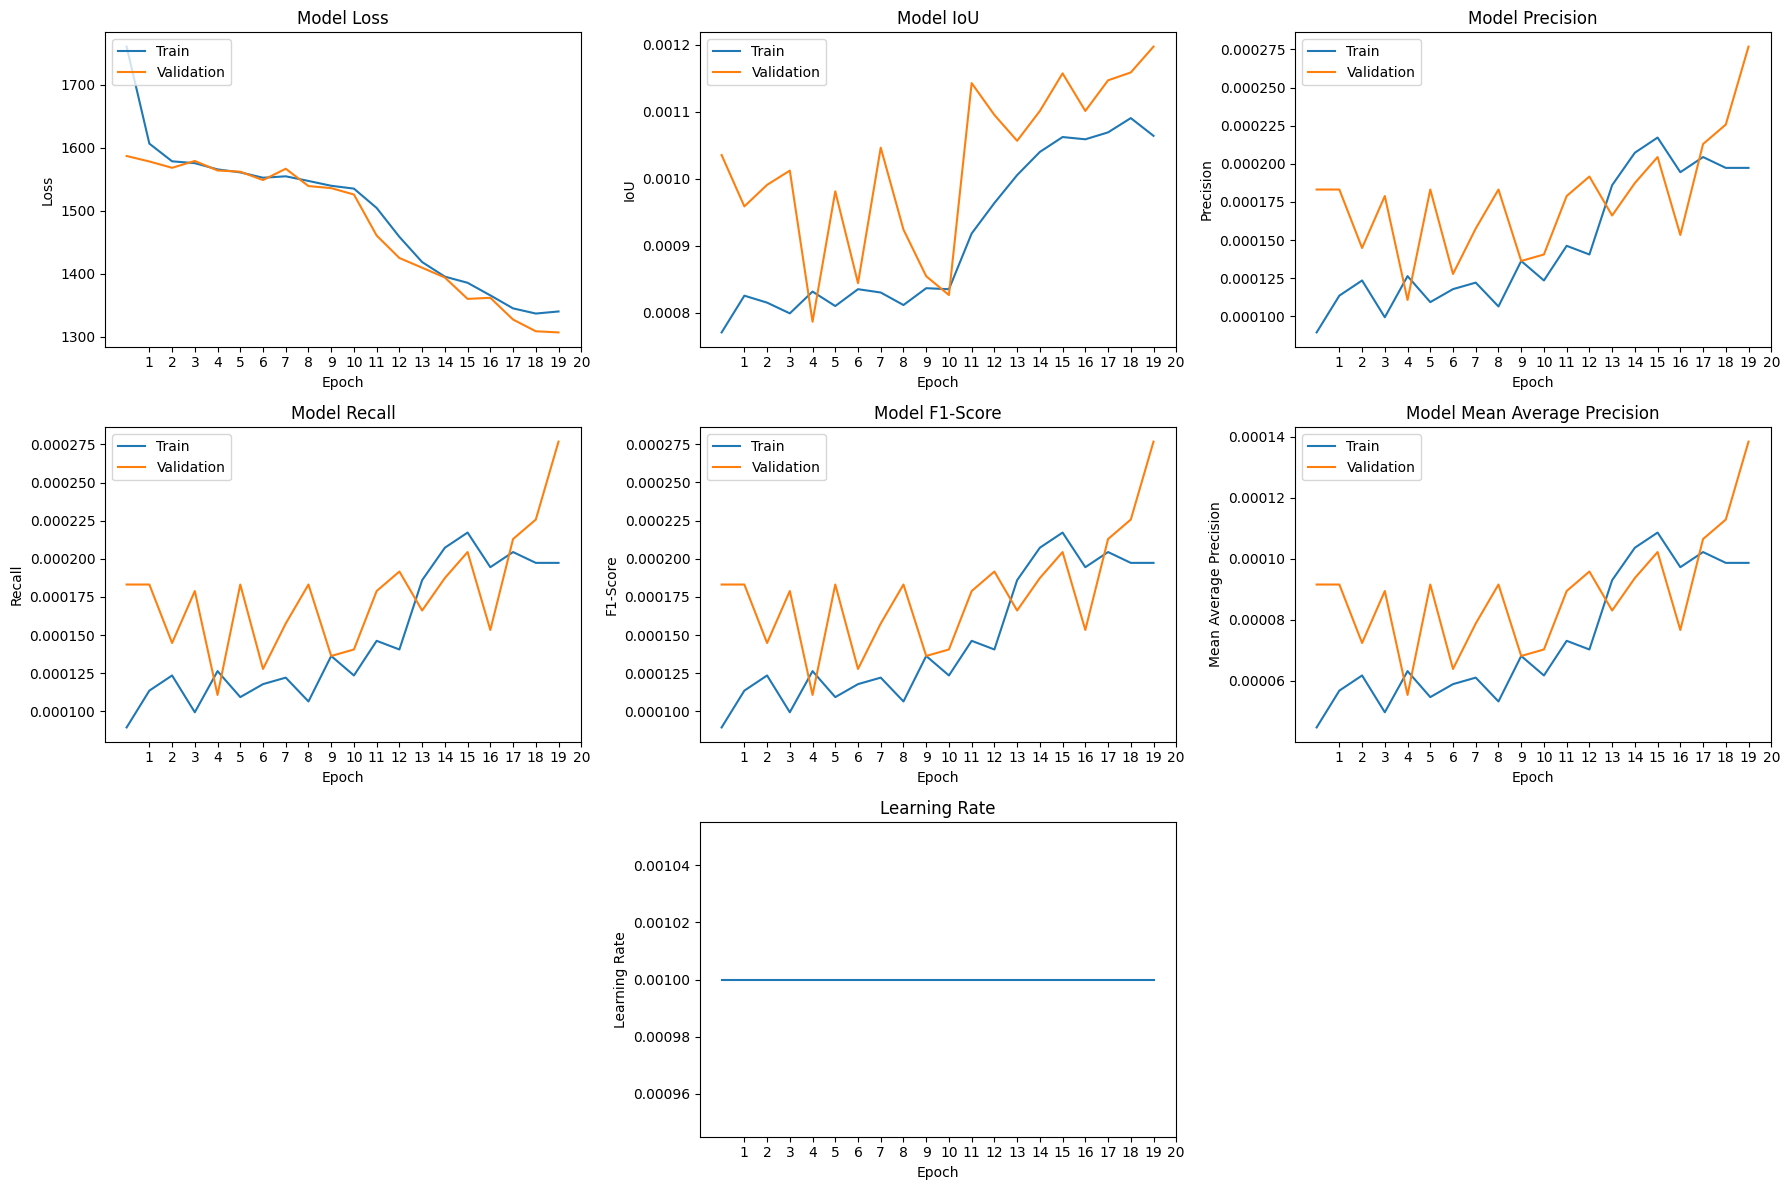

In [67]:
plot_metrics(history)

In [13]:
# Save the entire model
custom_cnn_model1.save(SAVE_PATH + 'custom_cnn_model1.keras')

In [14]:
model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras', custom_objects={'IoU': IoU, 'PrecisionMetric': PrecisionMetric, 'RecallMetric': RecallMetric, 'F1ScoreMetric': F1ScoreMetric, 'MeanAveragePrecision': MeanAveragePrecision})

In [15]:
# Load the model from a file
# custom_cnn_model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras')
gc.collect()

37601

## Custom CNN 2

In [16]:
class CustomCNNModel2:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])
        
    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        # roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule

# Initialize the CustomCNNModel class
custom_cnn_model2 = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model2.compile_model()

custom_cnn_model2.model.summary()

Using device: /GPU:0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (No

In [17]:
# Train the model
history2 = custom_cnn_model2.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model2.evaluate(test_dataset)

Epoch 1/20
190/190 [==============================] - 30s 154ms/step - loss: 1751.9915 - IoU: 7.7769e-04 - precision: 5.7926e-04 - recall: 5.7926e-04 - f1_score: 5.7921e-04 - mean_average_precision: 2.8960e-04 - val_loss: 1680.8722 - val_IoU: 6.0591e-04 - val_precision: 4.0037e-04 - val_recall: 4.0037e-04 - val_f1_score: 4.0032e-04 - val_mean_average_precision: 2.0016e-04 - lr: 0.0010
Epoch 2/20
190/190 [==============================] - 28s 149ms/step - loss: 1620.7174 - IoU: 7.9636e-04 - precision: 5.5796e-04 - recall: 5.5796e-04 - f1_score: 5.5791e-04 - mean_average_precision: 2.7895e-04 - val_loss: 1565.1512 - val_IoU: 8.8174e-04 - val_precision: 7.4537e-04 - val_recall: 7.4537e-04 - val_f1_score: 7.4532e-04 - val_mean_average_precision: 3.7266e-04 - lr: 0.0010
Epoch 3/20
190/190 [==============================] - 28s 147ms/step - loss: 1587.1415 - IoU: 8.2724e-04 - precision: 6.4740e-04 - recall: 6.4740e-04 - f1_score: 6.4735e-04 - mean_average_precision: 3.2368e-04 - val_loss: 15

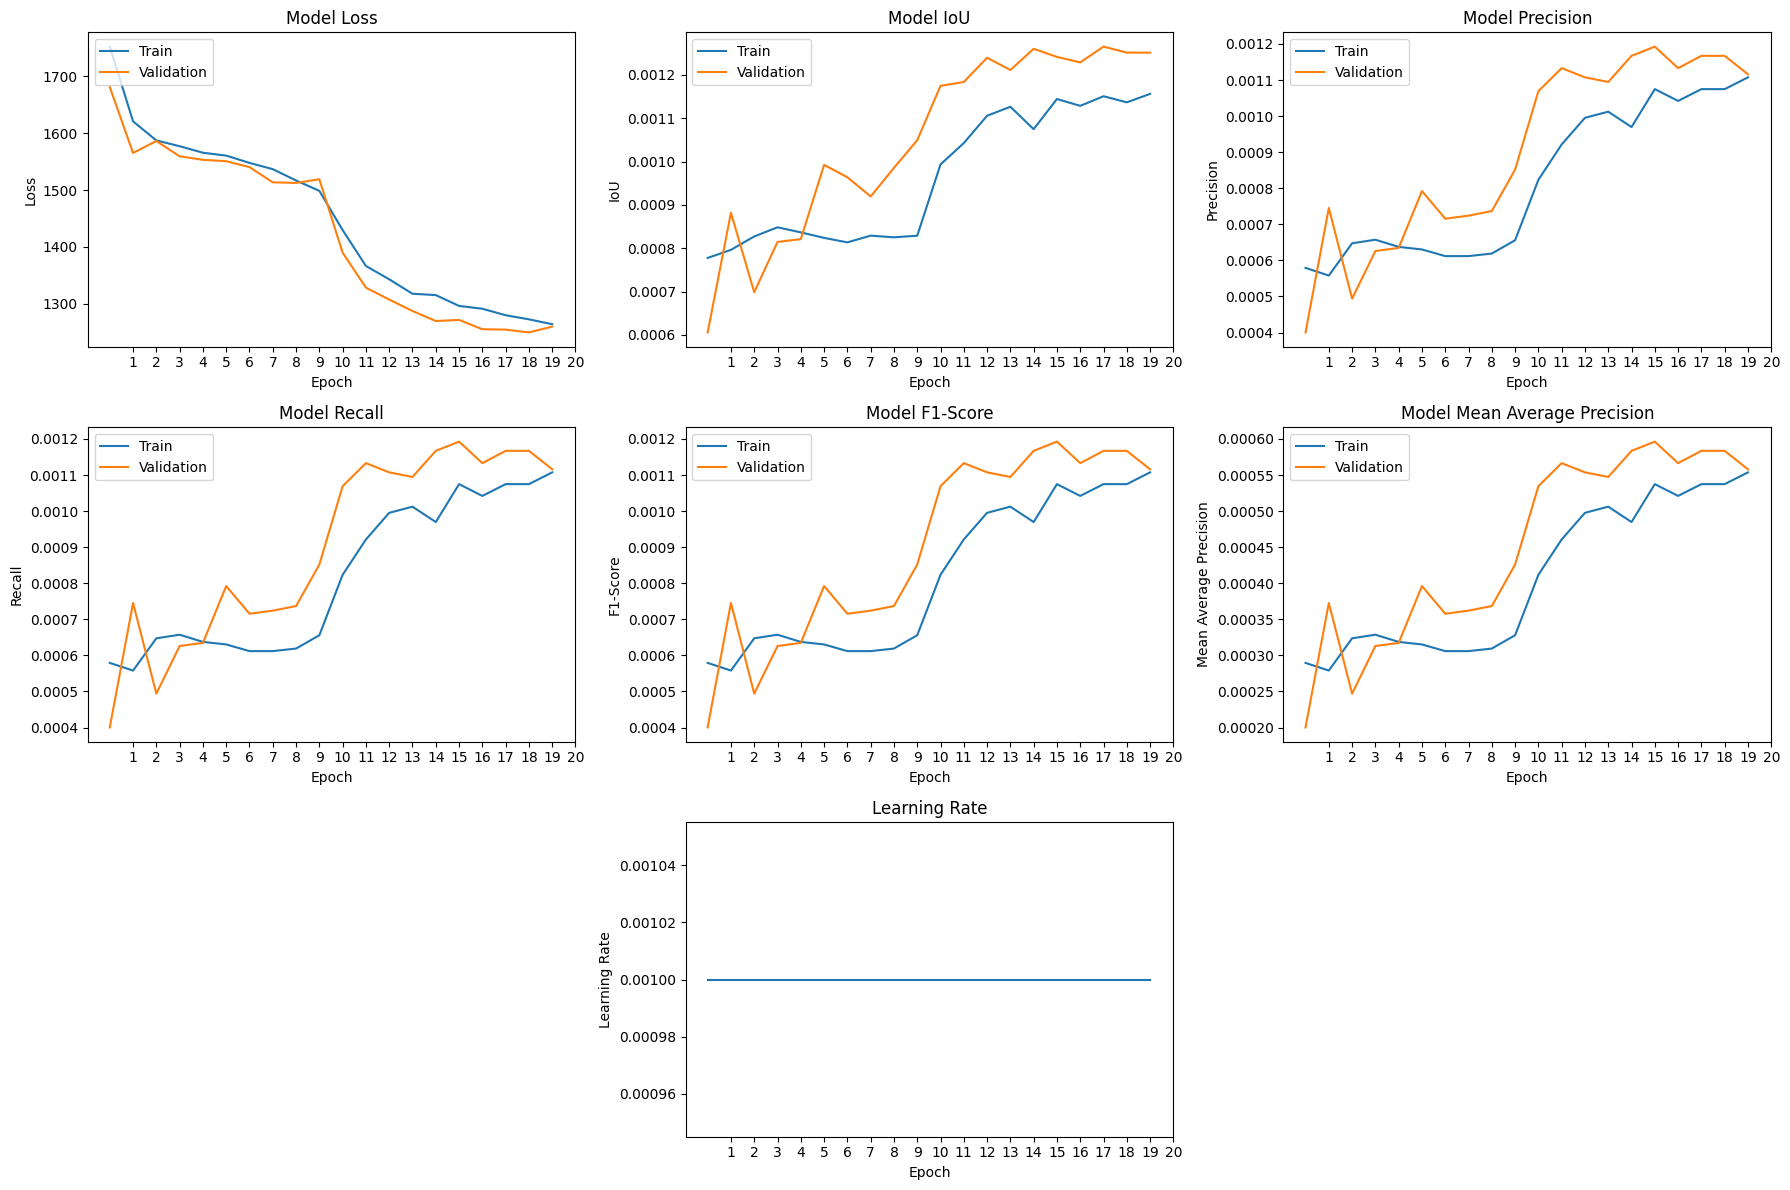

In [18]:
plot_metrics(history2)

In [19]:
# Save the entire model
custom_cnn_model2.save(SAVE_PATH + 'custom_cnn_model2.keras')

In [20]:
# Load the model from a file
# custom_cnn_model2 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras')
gc.collect()

38398

## Custom CNN 3

In [21]:
class CustomCNNModel3:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fifth Convolutional Block
            model.add(Conv2D(512, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
            model.add(Reshape((self.num_bboxes, 4)))
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()
        # roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)
        
    # def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
    #     def schedule(epoch):
    #         return initial_lr * (decay_factor ** (epoch // step_size))
    #     return schedule

# Initialize the CustomCNNModel class
custom_cnn_model3 = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model3.compile_model()

custom_cnn_model3.model.summary()

Using device: /GPU:0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                 

In [22]:
# Train the model
history3 = custom_cnn_model3.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model3.evaluate(test_dataset)

Epoch 1/20
190/190 [==============================] - 36s 184ms/step - loss: 1494.0852 - IoU: 9.5846e-04 - precision: 7.6240e-04 - recall: 7.6240e-04 - f1_score: 7.6235e-04 - mean_average_precision: 3.8118e-04 - val_loss: 2647.7251 - val_IoU: 3.6415e-04 - val_precision: 2.6833e-04 - val_recall: 2.6833e-04 - val_f1_score: 2.6828e-04 - val_mean_average_precision: 1.3414e-04 - lr: 0.0010
Epoch 2/20
190/190 [==============================] - 34s 176ms/step - loss: 1243.8204 - IoU: 0.0011 - precision: 0.0010 - recall: 0.0010 - f1_score: 0.0010 - mean_average_precision: 5.0114e-04 - val_loss: 2352.7668 - val_IoU: 4.8524e-04 - val_precision: 4.0889e-04 - val_recall: 4.0889e-04 - val_f1_score: 4.0884e-04 - val_mean_average_precision: 2.0442e-04 - lr: 0.0010
Epoch 3/20
190/190 [==============================] - 34s 178ms/step - loss: 1193.4440 - IoU: 0.0012 - precision: 0.0011 - recall: 0.0011 - f1_score: 0.0011 - mean_average_precision: 5.6645e-04 - val_loss: 1607.4099 - val_IoU: 9.8829e-04 - 

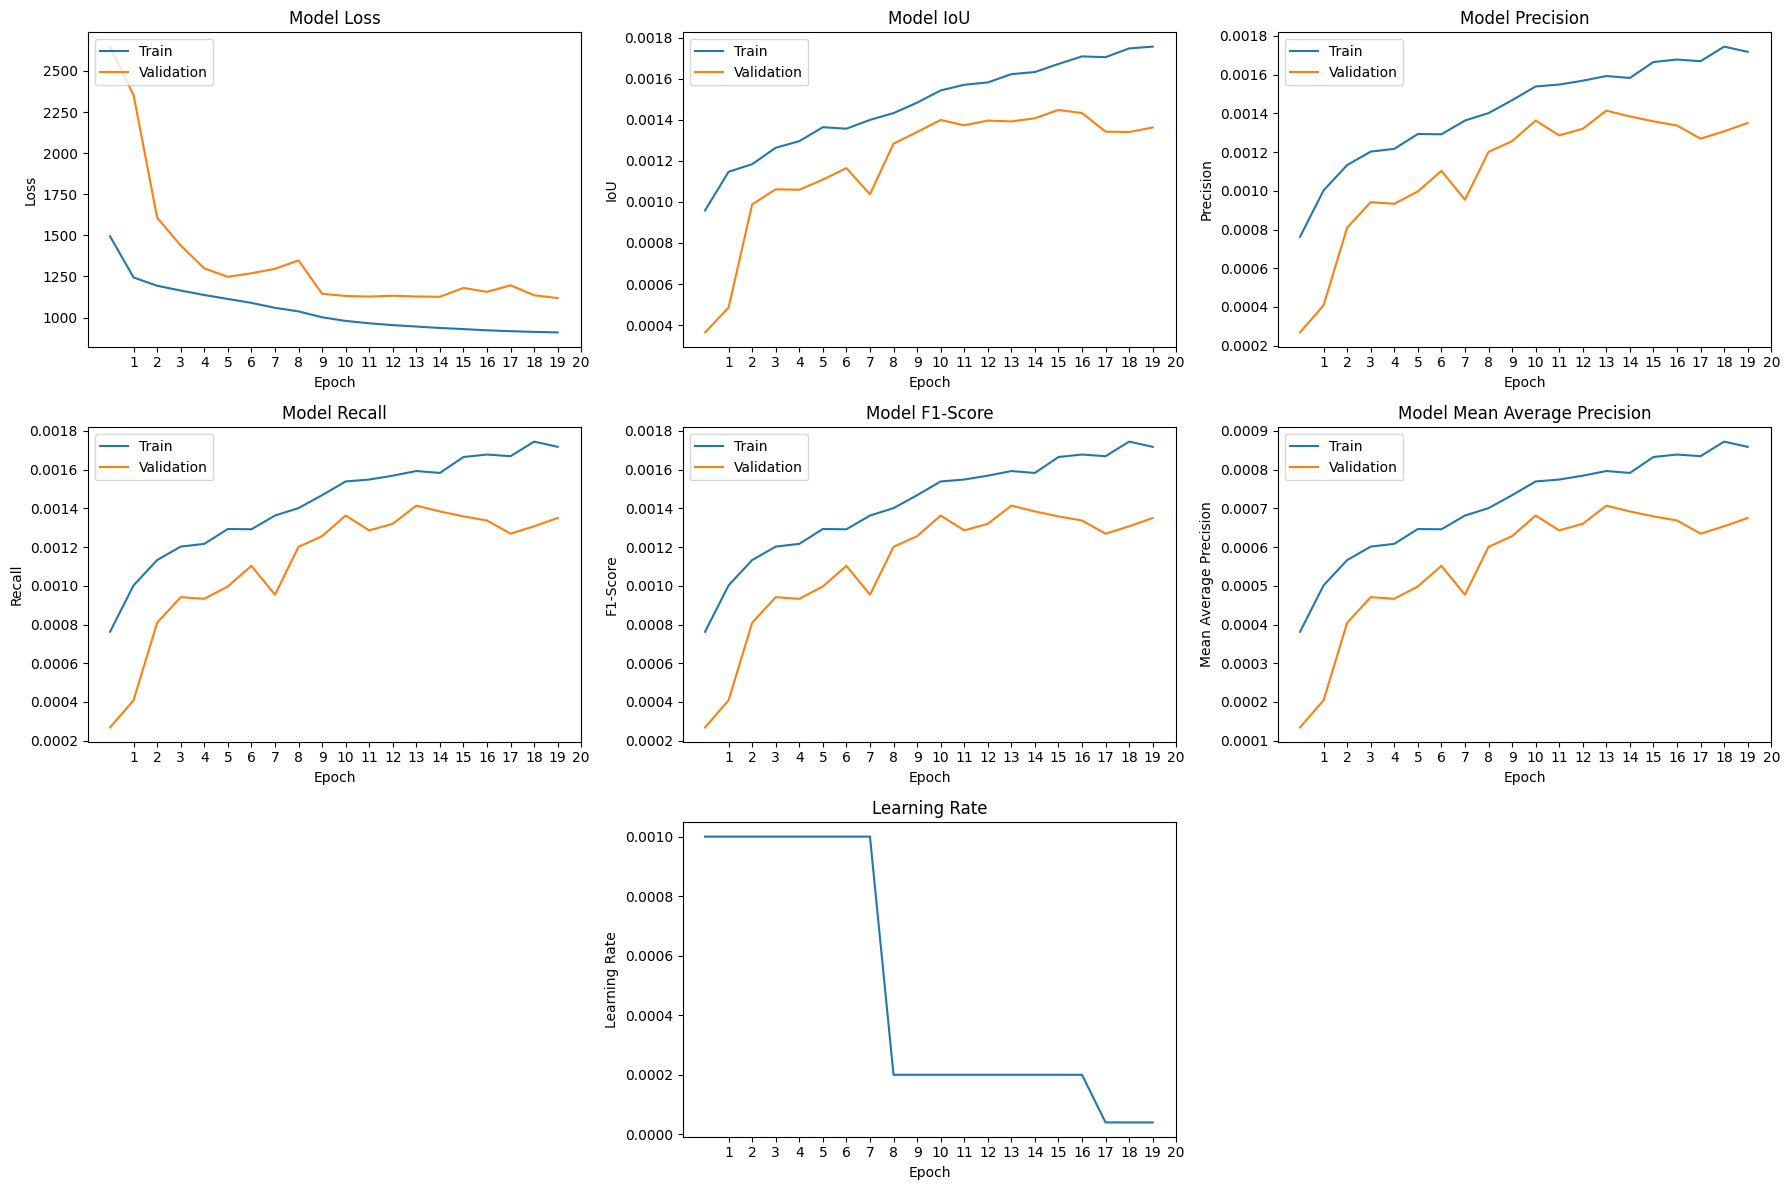

In [23]:
plot_metrics(history3)

In [24]:
# Save the entire model
custom_cnn_model3.save(SAVE_PATH + 'custom_cnn_model3.keras')

In [25]:
# Load the model from a file
# custom_cnn_model3 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model3.keras')
gc.collect()

38289

# Saving History

In [26]:
import pickle

with open('training_history_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

with open('training_history_2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)
    
with open('training_history_3.pkl', 'wb') as file:
    pickle.dump(history3.history, file)

Using device: /GPU:0


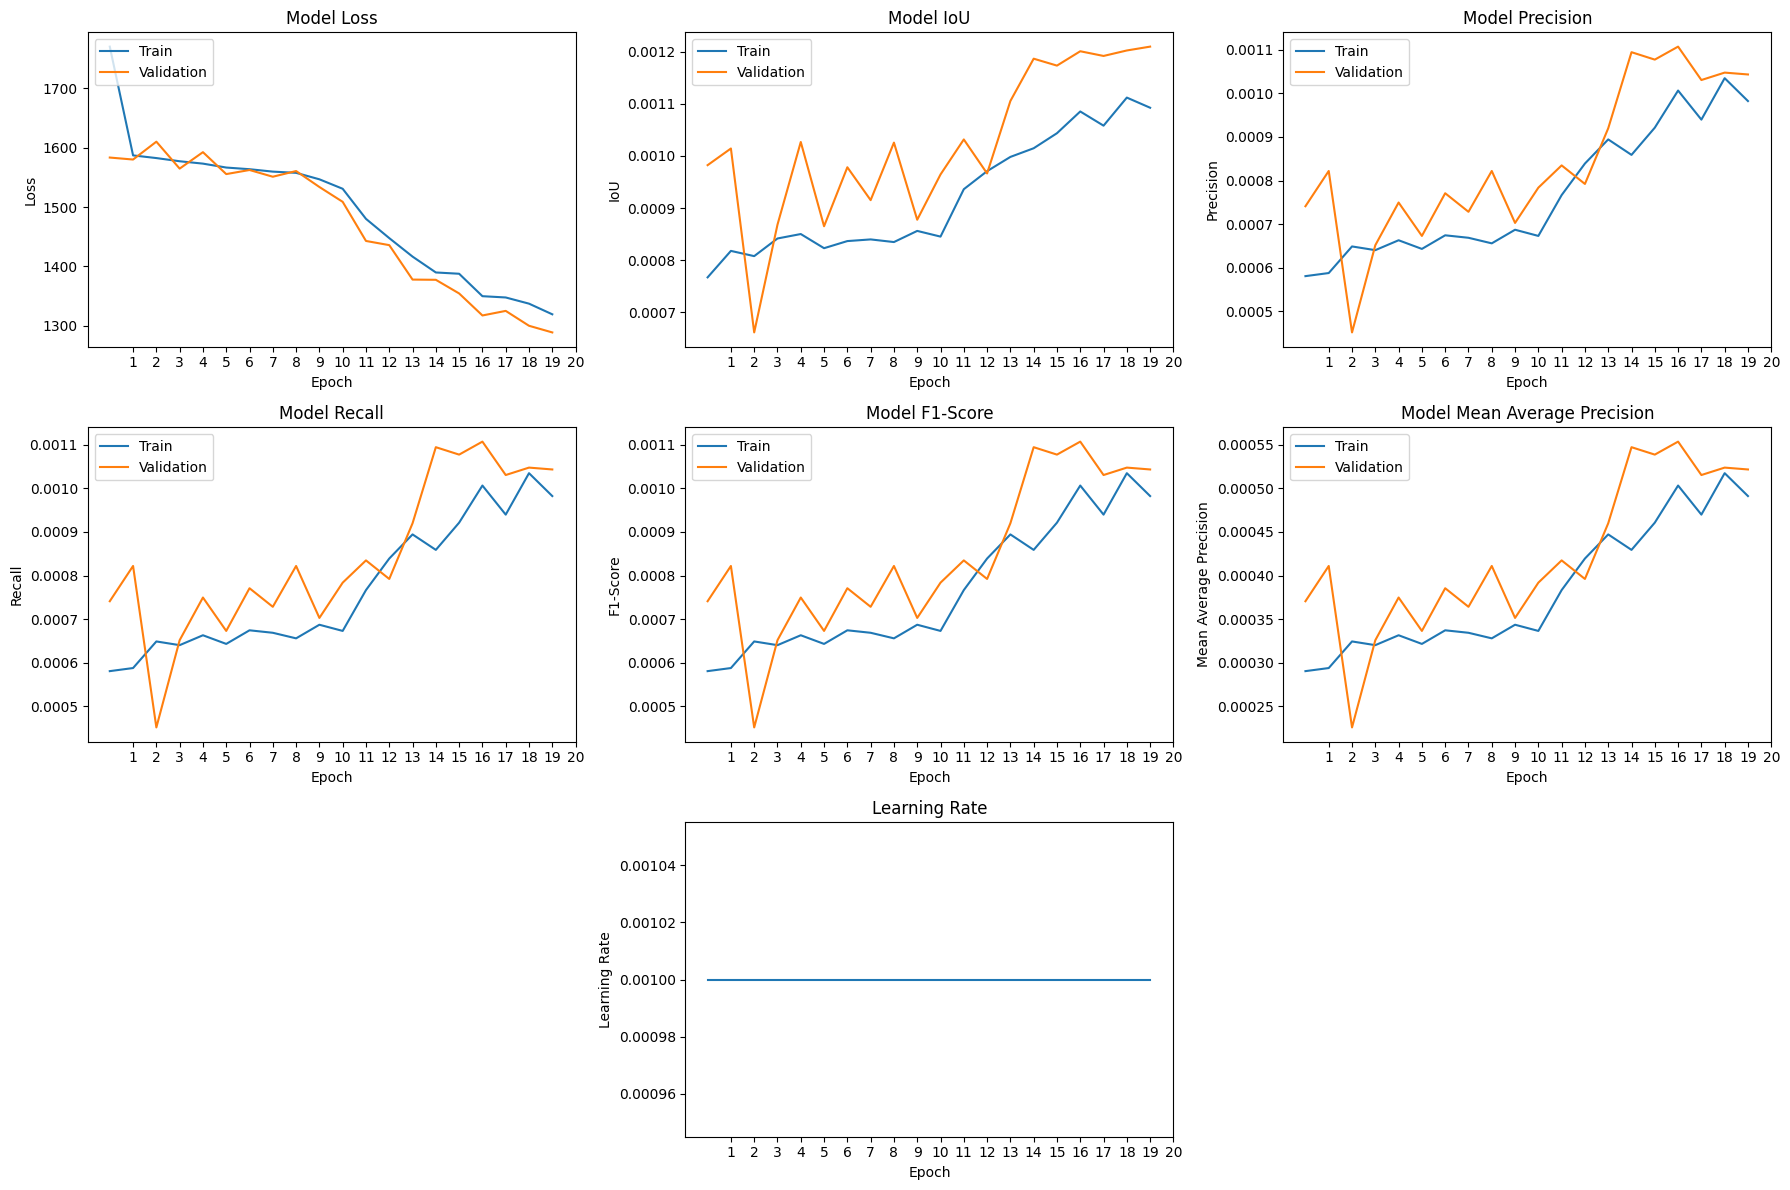

In [27]:
with open('training_history_1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


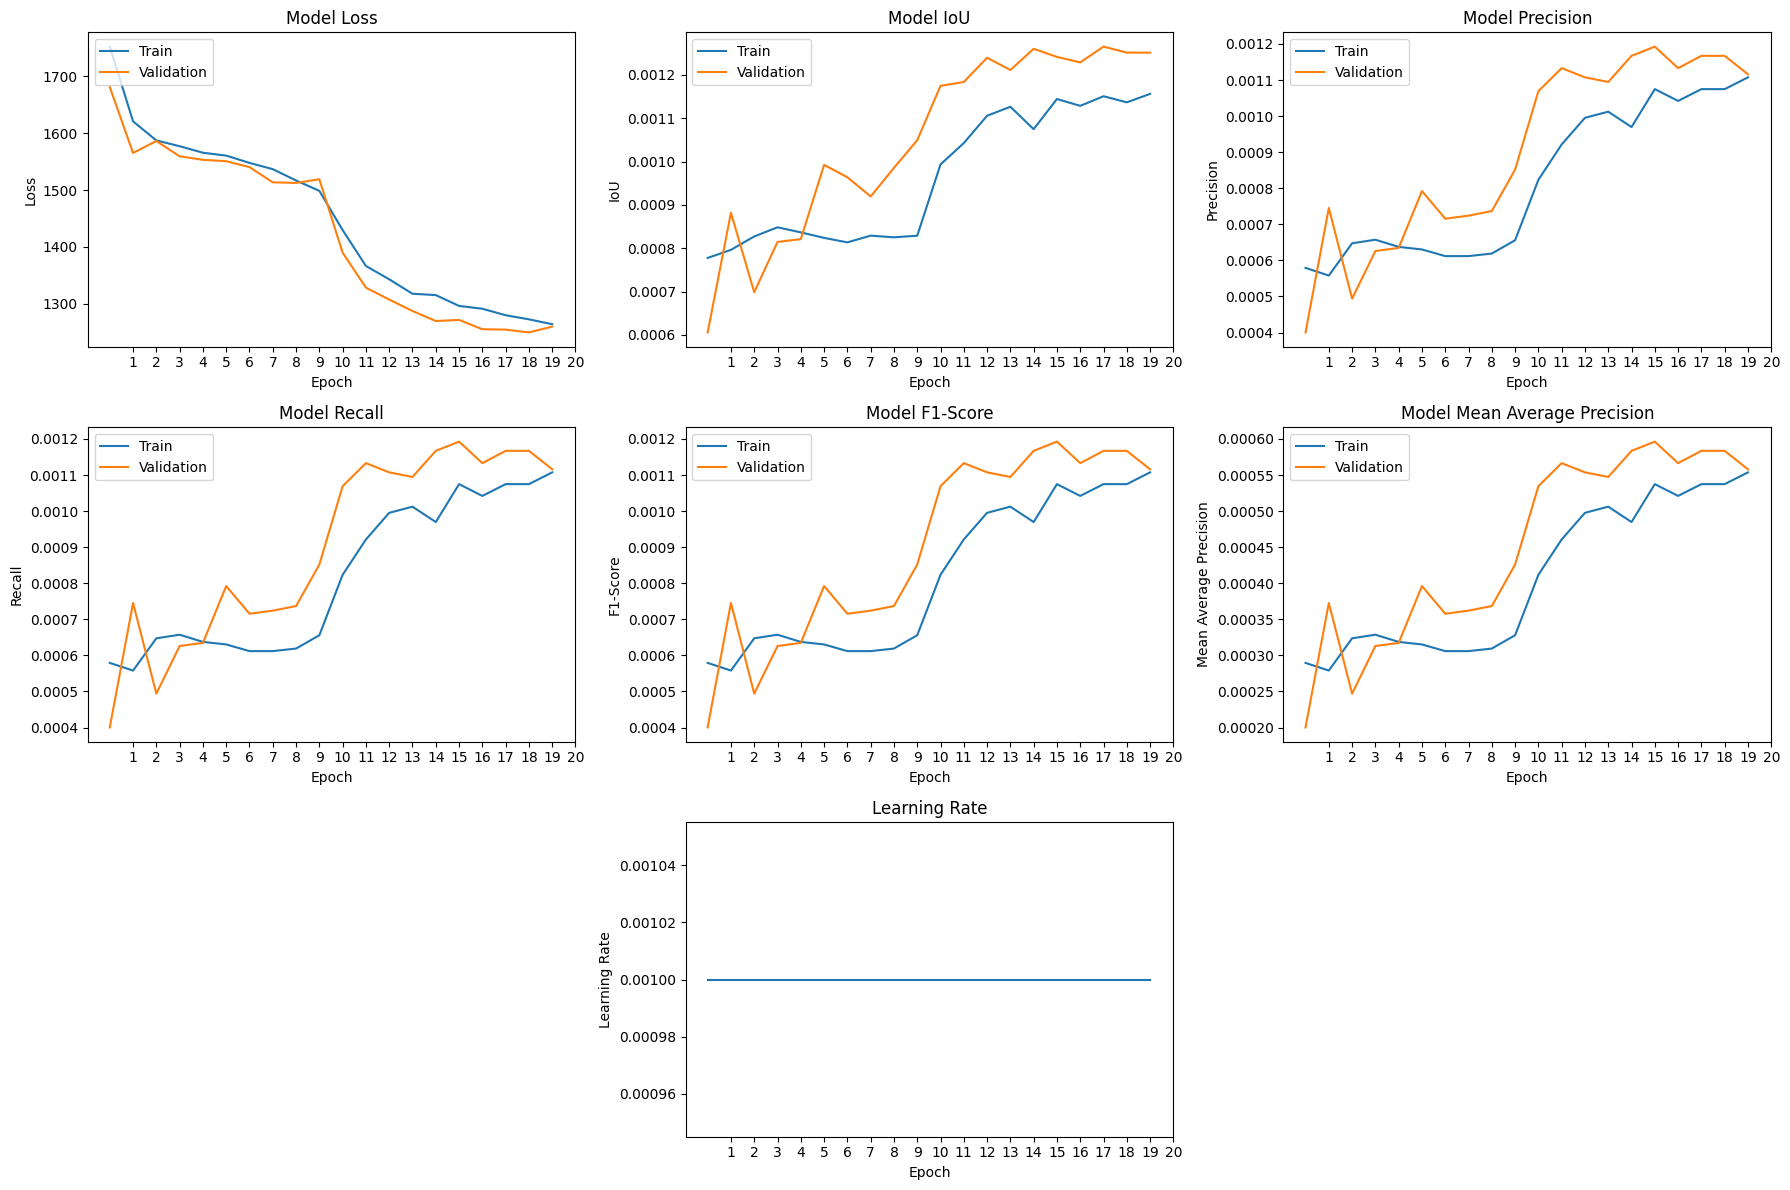

In [28]:
with open('training_history_2.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


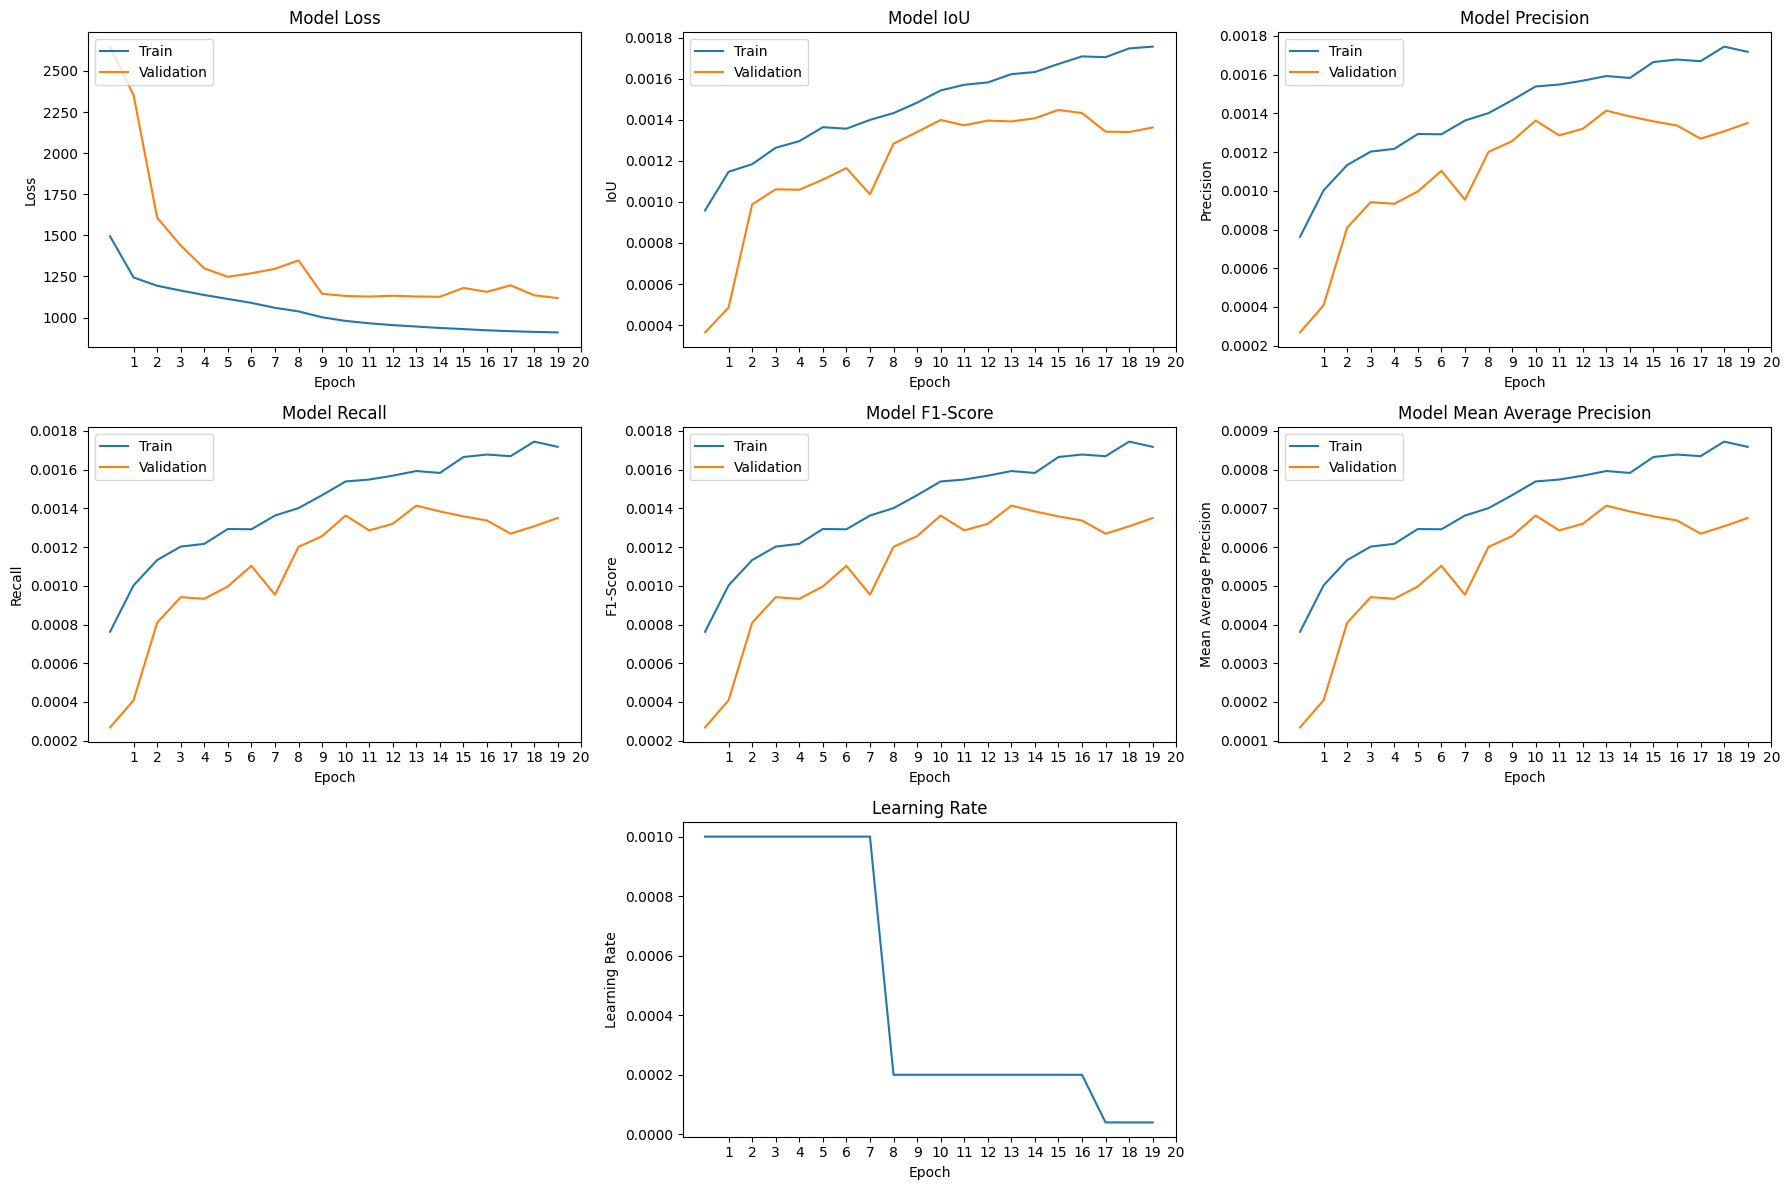

In [29]:
with open('training_history_3.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

# Hyperparameter tuning for Custom CNN 1

In [30]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=128, max_value=256, step=128), (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.4, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        model.add(Reshape((self.num_bboxes, 4)))

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'BestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()

        # Add callbacks to kwargs
        if 'callbacks' not in kwargs:
            kwargs['callbacks'] = []
        kwargs['callbacks'].extend([early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

        return model.fit(*args, **kwargs)
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model1',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_lr = best_hyperparameters.get('learning_rate')
print(f"Best optimizer: {best_lr}")

Trial 30 Complete [00h 07m 33s]
val_loss: 1133.7962646484375

Best val_loss So Far: 1092.423583984375
Total elapsed time: 01h 19m 17s
64/64 [==============================] - 1s 21ms/step - loss: 1066.0236
{'conv_5_filters': 128, 'dropout_rate': 0.4, 'learning_rate': 0.003584969783599317, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Best optimizer: 0.003584969783599317


In [31]:
# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'BestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_logging_callback = LrLoggingCallback()
# roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IoU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Epoch 1/20
190/190 [==============================] - 22s 108ms/step - loss: 1456.2942 - IoU: 9.8437e-04 - precision: 8.5469e-04 - recall: 8.5469e-04 - f1_score: 8.5464e-04 - mean_average_precision: 4.2732e-04 - val_loss: 2546.8379 - val_IoU: 9.0729e-04 - val_precision: 6.3037e-04 - val_recall: 6.3037e-04 - val_f1_score: 6.3032e-04 - val_mean_average_precision: 3.1516e-04 - lr: 0.0036
Epoch 2/20
190/190 [==============================] - 19s 102ms/step - loss: 1287.6097 - IoU: 0.0012 - precision: 0.0010 - recall: 0.0010 - f1_score: 0.0010 - mean_average_precision: 5.1037e-04 - val_loss: 2086.9028 - val_IoU: 6.7718e-04 - val_precision: 5.0685e-04 - val_recall: 5.0685e-04 - val_f1_score: 5.0680e-04 - val_mean_average_precision: 2.5340e-04 - lr: 0.0036
Epoch 3/20
190/190 [==============================] - 19s 102ms/step - loss: 1235.0833 - IoU: 0.0012 - precision: 0.0011 - recall: 0.0011 - f1_score: 0.0011 - mean_average_precision: 5.6574e-04 - val_loss: 1538.9567 - val_IoU: 8.0924e-04 - 

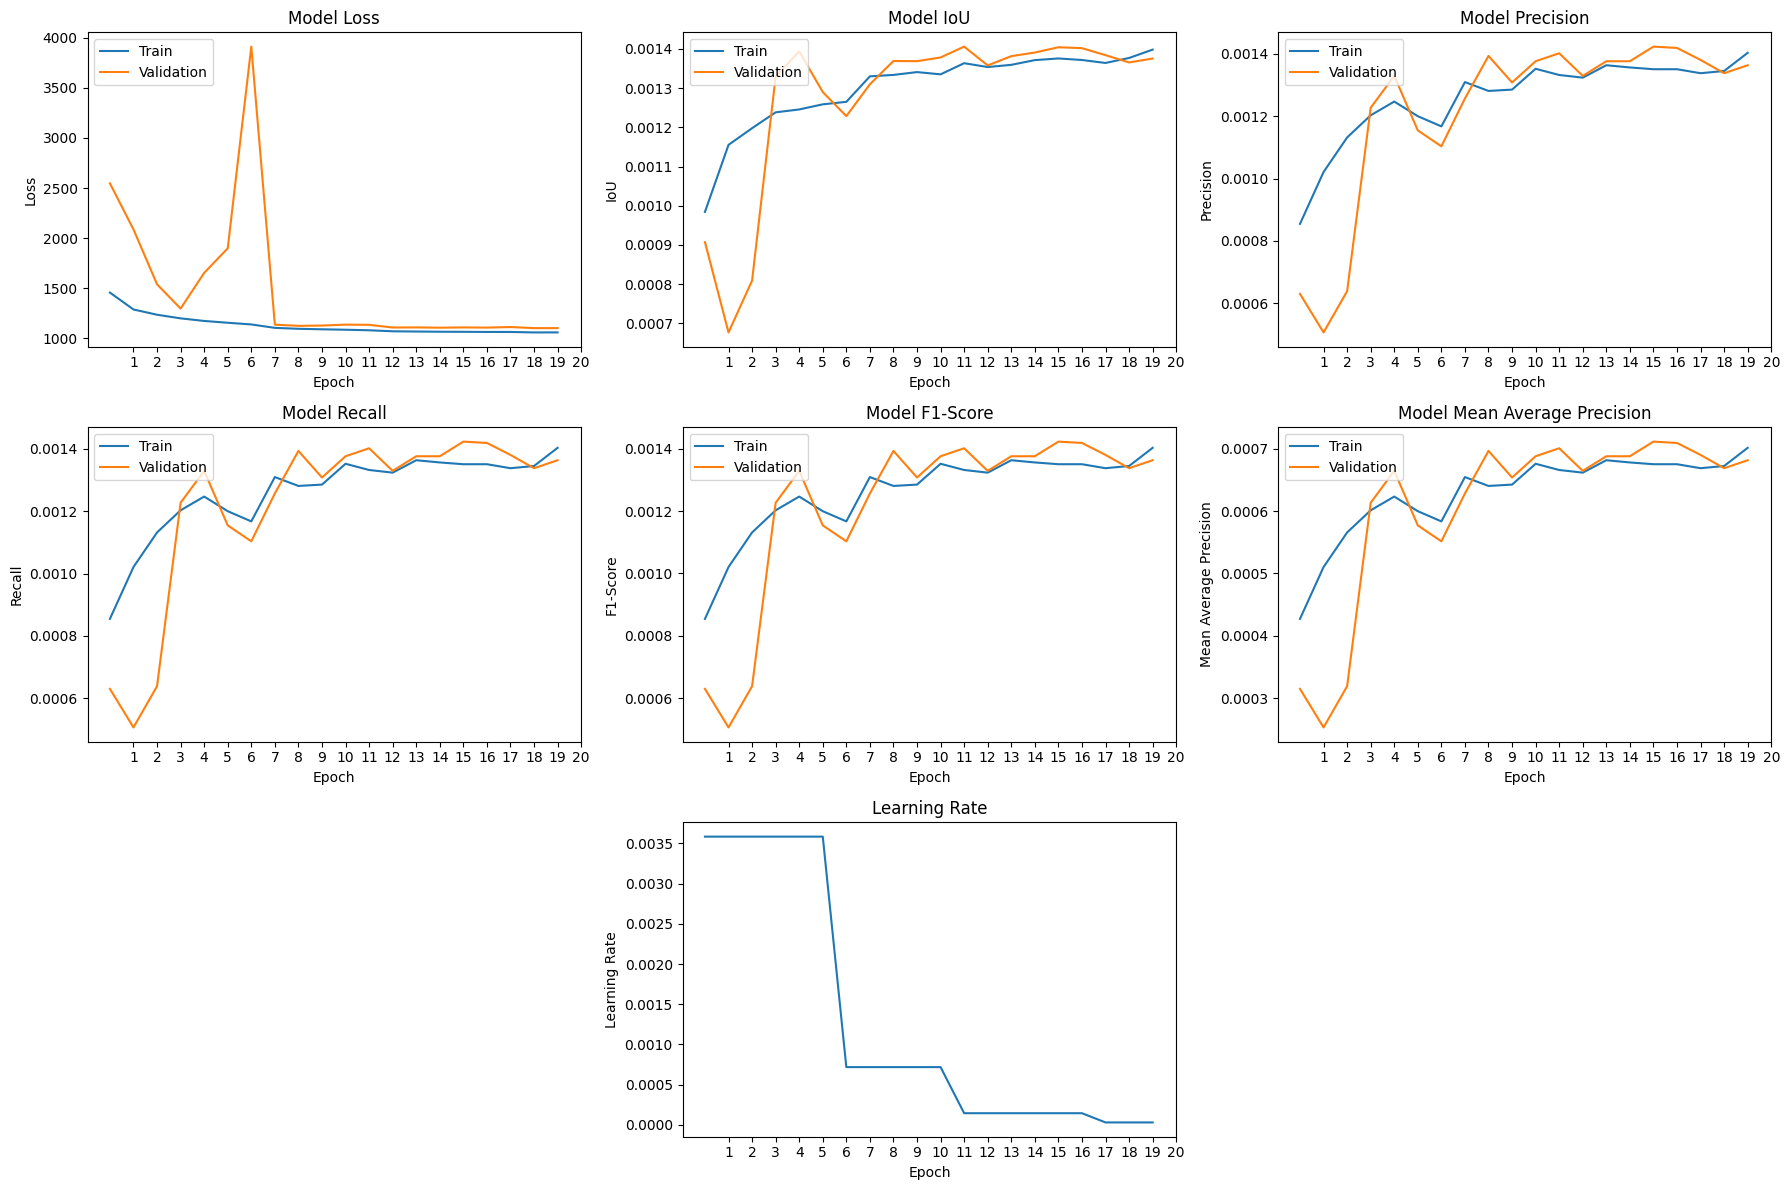

In [32]:
plot_metrics(history_best)

In [33]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model1.keras')

# Hyperparameter tuning for Custom CNN 2

In [34]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        # Fourth Convolutional Block
        model.add(Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=512, step=256), (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.4, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        model.add(Reshape((self.num_bboxes, 4)))

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'BestCustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()

        # Add callbacks to kwargs
        if 'callbacks' not in kwargs:
            kwargs['callbacks'] = []
        kwargs['callbacks'].extend([early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

        return model.fit(*args, **kwargs)
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        # fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model2',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_lr = best_hyperparameters.get('learning_rate')
print(f"Best optimizer: {best_lr}")

Trial 30 Complete [00h 07m 07s]
val_loss: 1167.0614013671875

Best val_loss So Far: 1104.4775390625
Total elapsed time: 01h 23m 59s
64/64 [==============================] - 2s 23ms/step - loss: 1087.7518
{'conv_4_filters': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0006115466870160577, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
Best optimizer: 0.0006115466870160577


In [35]:
# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'BestCustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_logging_callback = LrLoggingCallback()
# roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IoU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Epoch 1/20
190/190 [==============================] - 23s 118ms/step - loss: 1543.4165 - IoU: 9.0839e-04 - precision: 7.5388e-04 - recall: 7.5388e-04 - f1_score: 7.5383e-04 - mean_average_precision: 3.7692e-04 - val_loss: 2830.1687 - val_IoU: 2.7975e-04 - val_precision: 1.4481e-04 - val_recall: 1.4481e-04 - val_f1_score: 1.4476e-04 - val_mean_average_precision: 7.2382e-05 - lr: 6.1155e-04
Epoch 2/20
190/190 [==============================] - 21s 113ms/step - loss: 1238.4434 - IoU: 0.0012 - precision: 0.0011 - recall: 0.0011 - f1_score: 0.0011 - mean_average_precision: 5.4019e-04 - val_loss: 2715.0369 - val_IoU: 4.1798e-04 - val_precision: 2.7685e-04 - val_recall: 2.7685e-04 - val_f1_score: 2.7680e-04 - val_mean_average_precision: 1.3840e-04 - lr: 6.1155e-04
Epoch 3/20
190/190 [==============================] - 21s 113ms/step - loss: 1183.6947 - IoU: 0.0012 - precision: 0.0011 - recall: 0.0011 - f1_score: 0.0011 - mean_average_precision: 5.6503e-04 - val_loss: 1744.7628 - val_IoU: 8.069

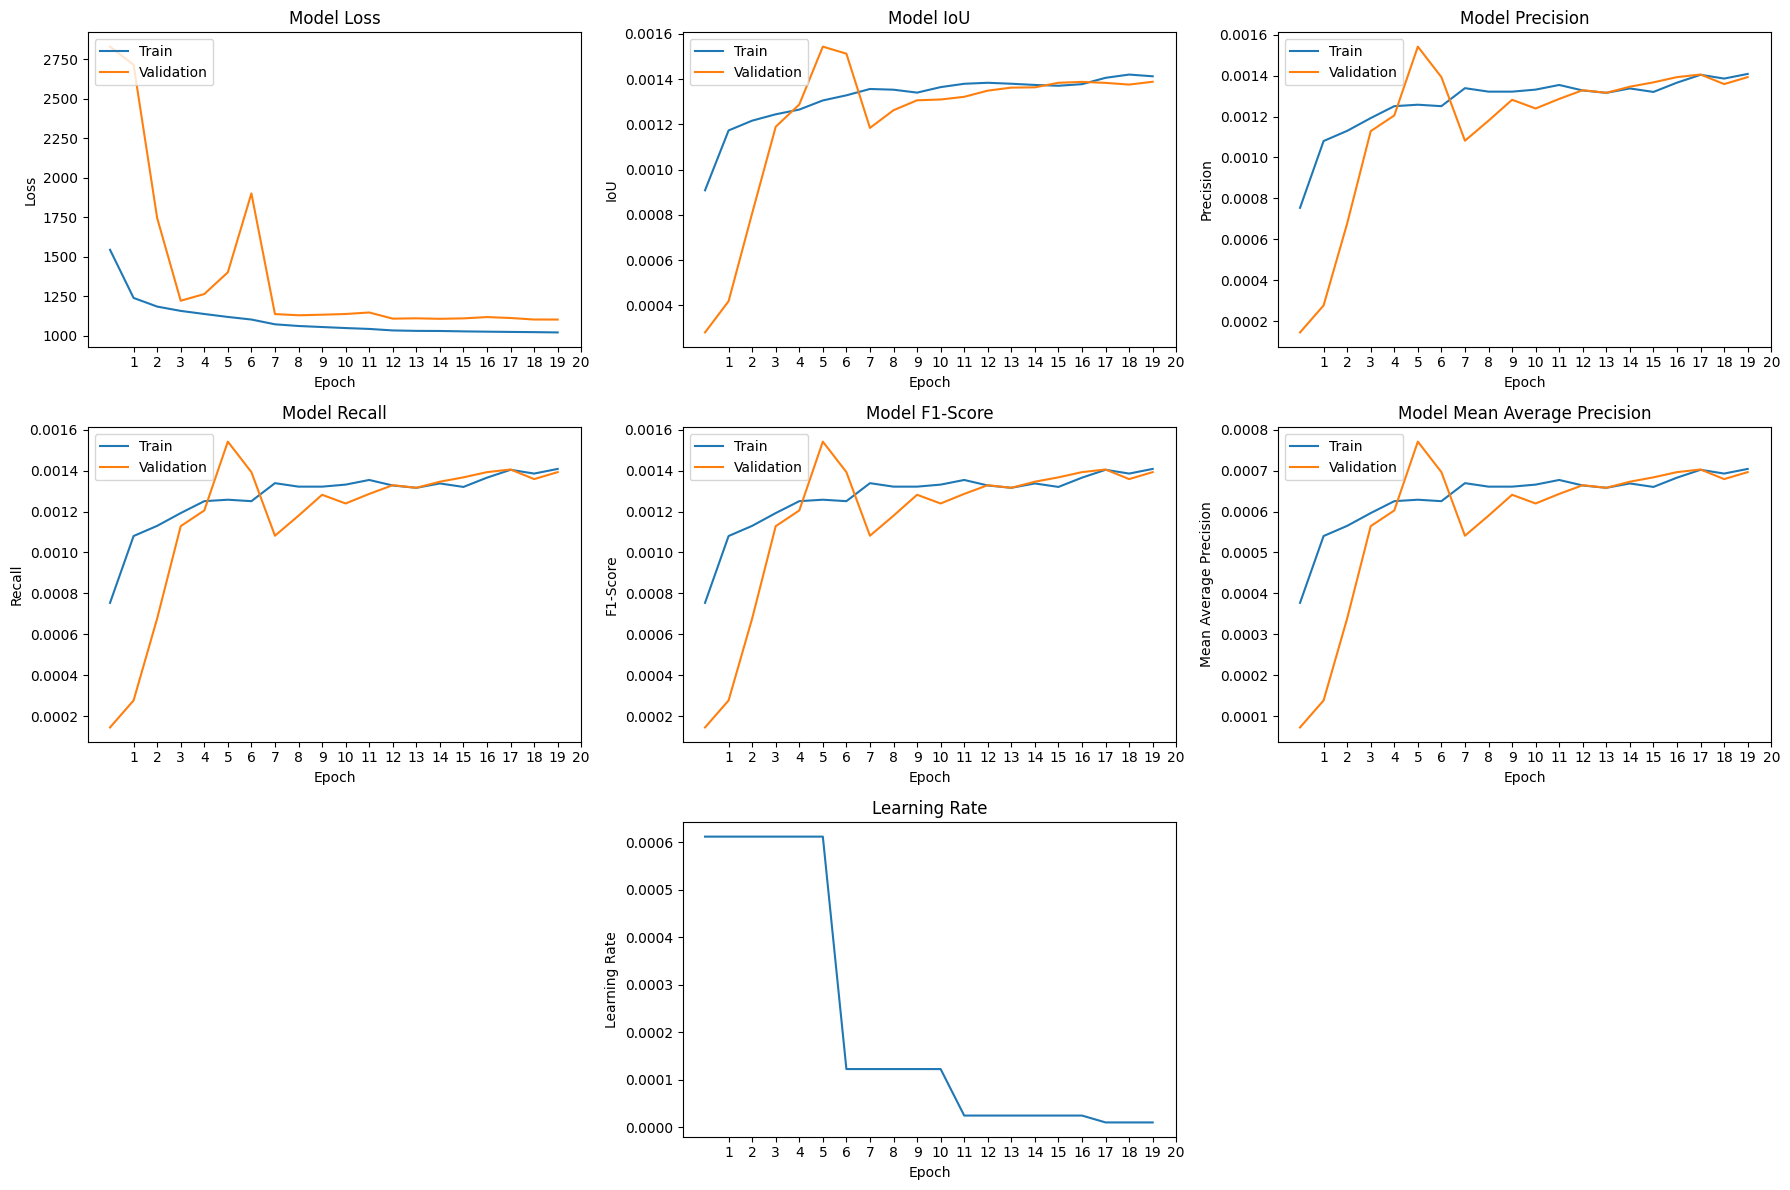

In [36]:
plot_metrics(history_best)

In [37]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model2.keras')

# Hyperparameter tuning for Custom CNN 3

In [38]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), max_bboxes=max_bboxes):
        self.input_shape = input_shape
        self.num_bboxes = max_bboxes
        self.output_shape = max_bboxes * 4

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(1024, (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fifth Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=512, max_value=1024, step=512), 
                         (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(self.output_shape, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        model.add(Reshape((self.num_bboxes, 4)))

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=5e-3, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'BestCustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_logging_callback = LrLoggingCallback()

        # Add callbacks to kwargs
        if 'callbacks' not in kwargs:
            kwargs['callbacks'] = []
        kwargs['callbacks'].extend([early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

        return model.fit(*args, **kwargs)
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, IoU_val, precision_val, recall_val, f1_score_val, map_val = results
        # lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, IoU: {IoU_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}')
        return {
            'loss': loss,
            'IoU': IoU_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model3',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model2 = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model2.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_lr = best_hyperparameters.get('learning_rate')
print(f"Best optimizer: {best_lr}")


Trial 30 Complete [00h 11m 29s]
val_loss: 1140.7584228515625

Best val_loss So Far: 1104.3831787109375
Total elapsed time: 02h 07m 48s
64/64 [==============================] - 2s 33ms/step - loss: 1080.3041
{'conv_5_filters': 512, 'dropout_rate': 0.5, 'learning_rate': 0.0019863189972498503, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
Best optimizer: 0.0019863189972498503


In [39]:
# Build the model using the best hyperparameters
best_model2 = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Compile the model with the optimizer
best_model2.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[IoU, PrecisionMetric(), RecallMetric(), F1ScoreMetric(), MeanAveragePrecision()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'BestCustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_logging_callback = LrLoggingCallback()
# roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best2 = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  lr_logging_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IoU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Epoch 1/20
190/190 [==============================] - 24s 125ms/step - loss: 1019.5452 - IoU: 0.0014 - precision: 0.0013 - recall: 0.0013 - f1_score: 0.0013 - mean_average_precision: 6.6229e-04 - val_loss: 1101.7451 - val_IoU: 0.0014 - val_precision: 0.0014 - val_recall: 0.0014 - val_f1_score: 0.0014 - val_mean_average_precision: 6.9210e-04 - lr: 1.0000e-05
Epoch 2/20
190/190 [==============================] - 25s 130ms/step - loss: 1019.4910 - IoU: 0.0014 - precision: 0.0014 - recall: 0.0014 - f1_score: 0.0014 - mean_average_precision: 6.7577e-04 - val_loss: 1101.4456 - val_IoU: 0.0014 - val_precision: 0.0014 - val_recall: 0.0014 - val_f1_score: 0.0014 - val_mean_average_precision: 6.7932e-04 - lr: 1.0000e-05
Epoch 3/20
190/190 [==============================] - 27s 144ms/step - loss: 1019.1605 - IoU: 0.0014 - precision: 0.0014 - recall: 0.0014 - f1_score: 0.0014 - mean_average_precision: 7.0914e-04 - val_loss: 1103.4791 - val_IoU: 0.0014 - val_precision: 0.0014 - val_recall: 0.0014 -

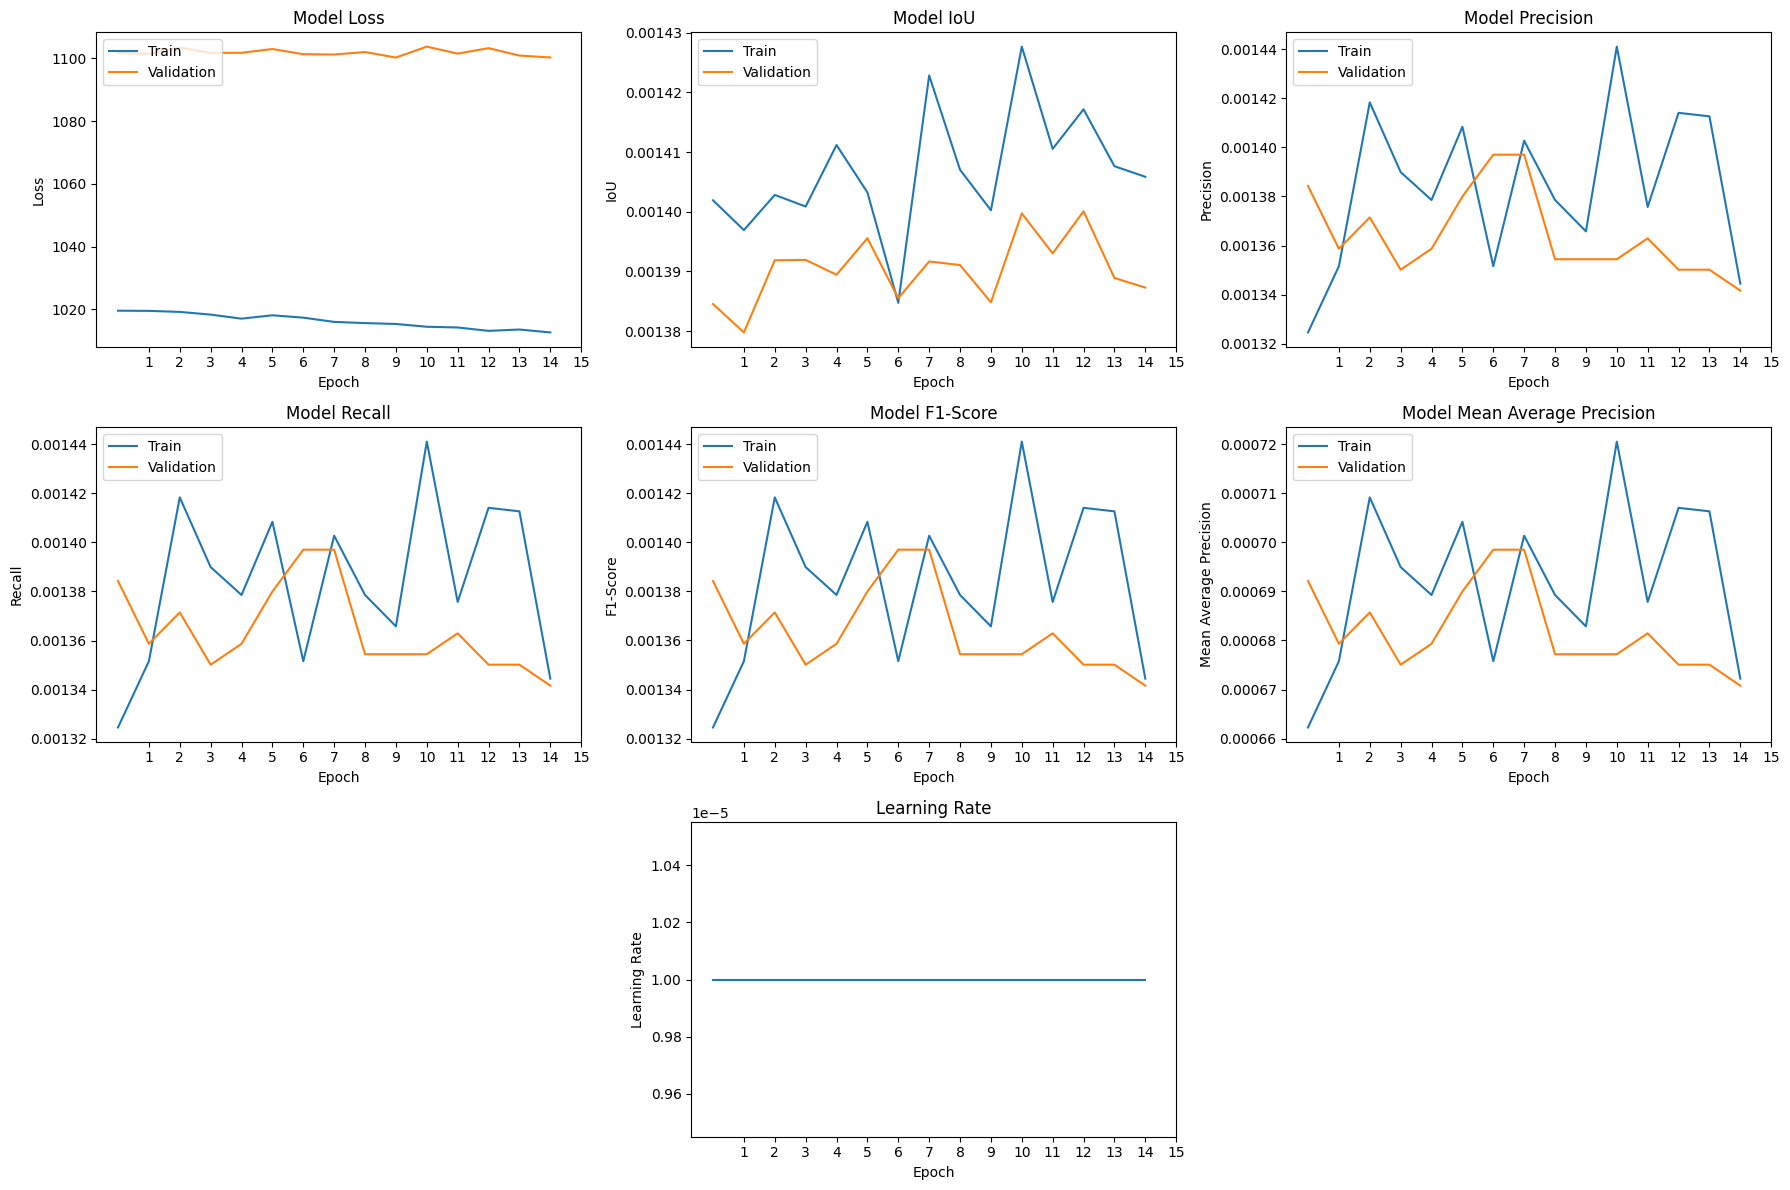

In [40]:
plot_metrics(history_best2)

In [41]:
best_model2.save(SAVE_PATH + 'best_custom_cnn_model3.keras')

In [42]:
gc.collect()

32843

# Testing

1/1 [==============================] - 0s 22ms/step


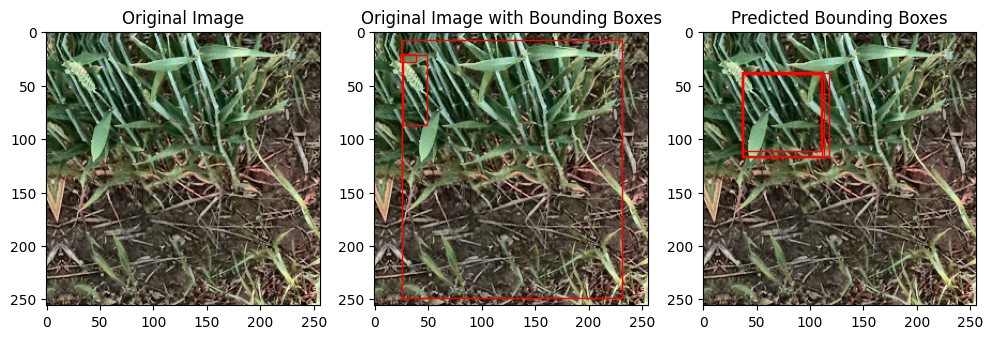

In [77]:
def filter_bboxes(bboxes, max_value=IMG_SIZE):
    all_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox
        if x + w > max_value or y + h > max_value:
            pass
        else:
            all_bboxes.append(bbox)
    areas = calculate_bbox_area(bboxes)
    max_area_index = areas.index(max(areas))
    bbox_with_max_area = bboxes[max_area_index]
    xmin, ymin, width, height = bbox_with_max_area
    xmax, ymax = xmin + width, ymin + height
    all_all_bboxes = []
    for bbox in all_bboxes:
        x, y, w, h = bbox
        if x >= xmin and x <= xmax:
            pass
        elif y >= ymin and y + h <= ymax:
            pass
        elif x + w >= xmin and x + w <= xmax:
            pass
        elif y + h >= ymin and y + h <= ymax:
            pass
        else:
            all_all_bboxes.append(bbox)
    return all_all_bboxes
    
def calculate_bbox_area(bboxes):
    areas = []
    for bbox in bboxes:
        ymin, xmin, ymax, xmax = bbox
        width = xmax - xmin
        height = ymax - ymin
        area = width * height
        areas.append(area)
    return areas

# Function to plot image with bounding boxes
def plot_image_with_bboxes(ax, image, bboxes, t_bboxes=None, num_plot=None, reverse=True):
    # fig, ax = plt.subplots(1)
    ax.imshow(image)
    if num_plot is not None:
        if num_plot > len(bboxes):
            area_threshold = sorted(calculate_bbox_area(bboxes), reverse=reverse)
        else:
            area_threshold = sorted(calculate_bbox_area(bboxes), reverse=reverse)[num_plot-1]
    # scale = tf.cast(1024, tf.float32) / 256
    # bboxes = bboxes * scale
    for i in range(len(bboxes)):
        # bbox format: [ymin, xmin, ymax, xmax]
        ymin, xmin, ymax, xmax = bboxes[i]
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        if num_plot is not None:
            if reverse:
                if width * height > area_threshold:
                    ax.add_patch(rect)
            if not reverse:
                if width * height < area_threshold:
                    ax.add_patch(rect)
        else:
            ax.add_patch(rect)
        if t_bboxes is not None and np.all(t_bboxes[i] == 0):
            break

def predict_bboxes(model, image_array):
    model=model.model
    image_array = tf.expand_dims(image_array, axis=0)  # Add an extra dimension to the image array
    predictions = model.predict(image_array)
    bboxes = predictions[0]  # Remove batch dimension
    return bboxes

# Load the model
model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras', custom_objects={'IoU': IoU, 'PrecisionMetric': PrecisionMetric, 'RecallMetric': RecallMetric, 'F1ScoreMetric': F1ScoreMetric, 'MeanAveragePrecision': MeanAveragePrecision})
# model = custom_cnn_model1

# Extract the image and bounding boxes
for x, y in test_dataset.take(1):
    image = x[20].numpy()
    bboxes = y[20].numpy()
    break

# Plot the original image
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')

# Plot the image with bounding boxes
plot_image_with_bboxes(axes[1], image, bboxes)
# axes[1].imshow(image)
axes[1].set_title('Original Image with Bounding Boxes')

scale = tf.cast(1024, tf.float32) / IMG_SIZE
bboxes_pred = predict_bboxes(model, image)
plot_image_with_bboxes(axes[2], image, bboxes_pred, bboxes)
# axes[2].imshow(image)
axes[2].set_title('Predicted Bounding Boxes')

plt.show()

1/1 [==============================] - 0s 17ms/step


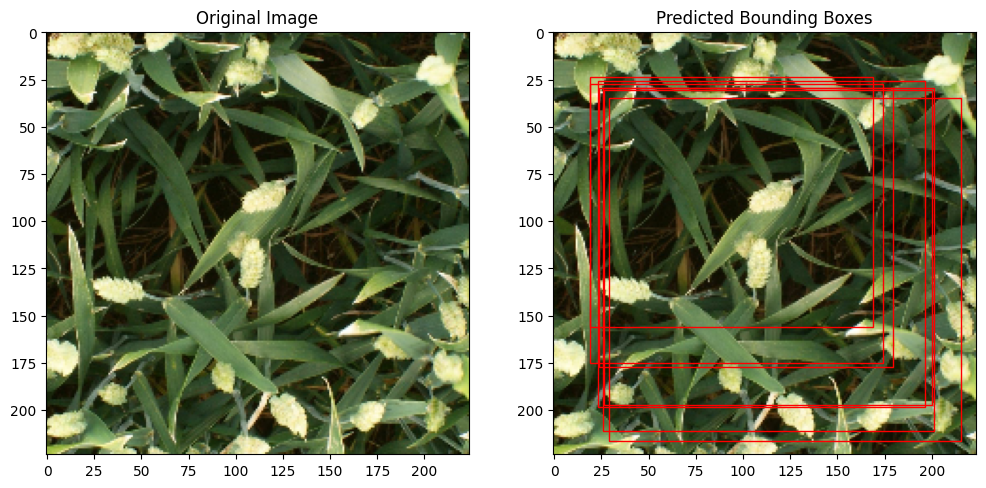

1/1 [==============================] - 0s 18ms/step


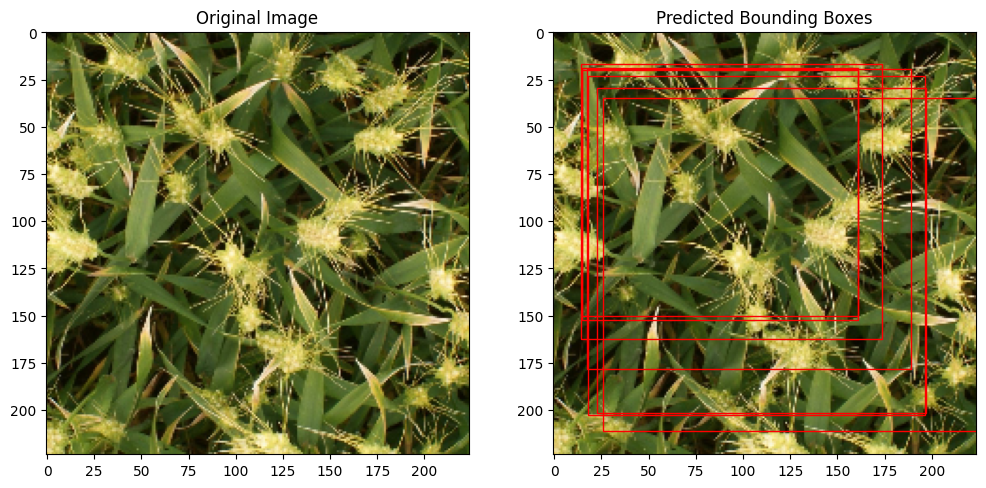

1/1 [==============================] - 0s 15ms/step


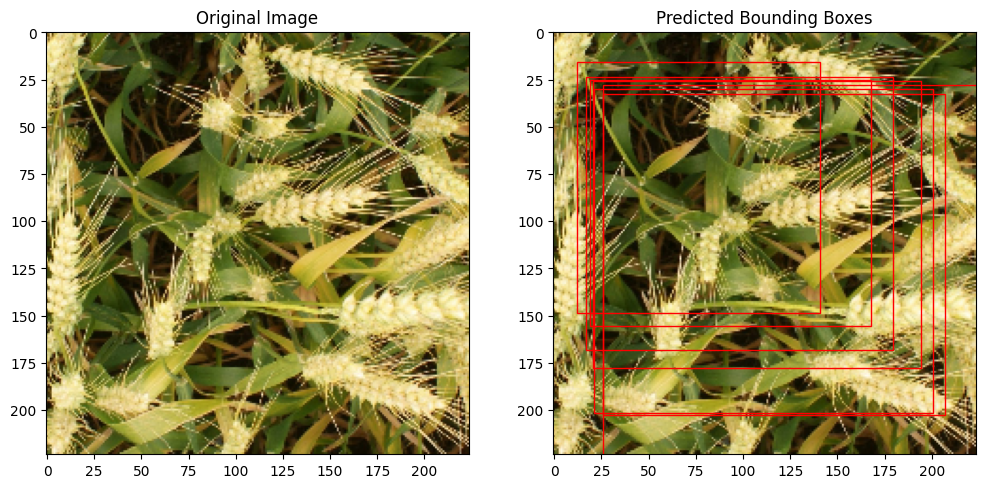

1/1 [==============================] - 0s 16ms/step


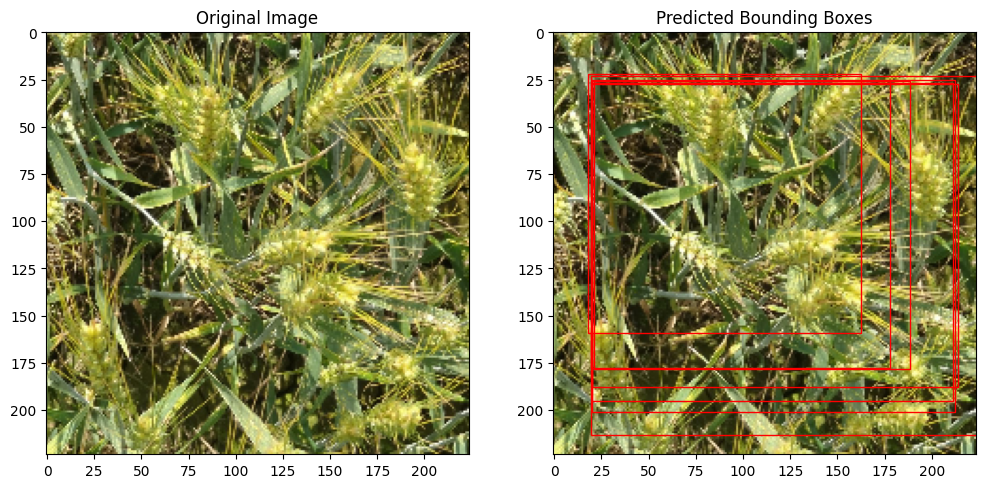

1/1 [==============================] - 0s 17ms/step


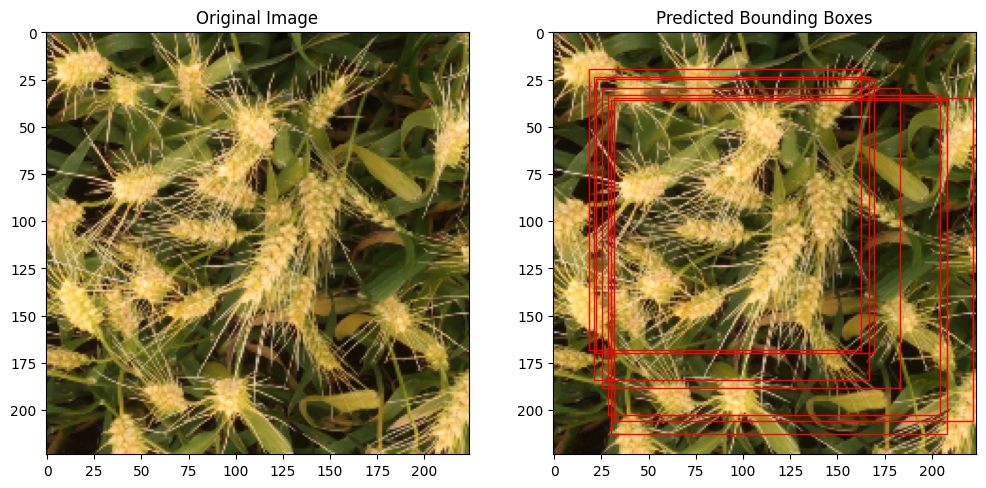

1/1 [==============================] - 0s 27ms/step


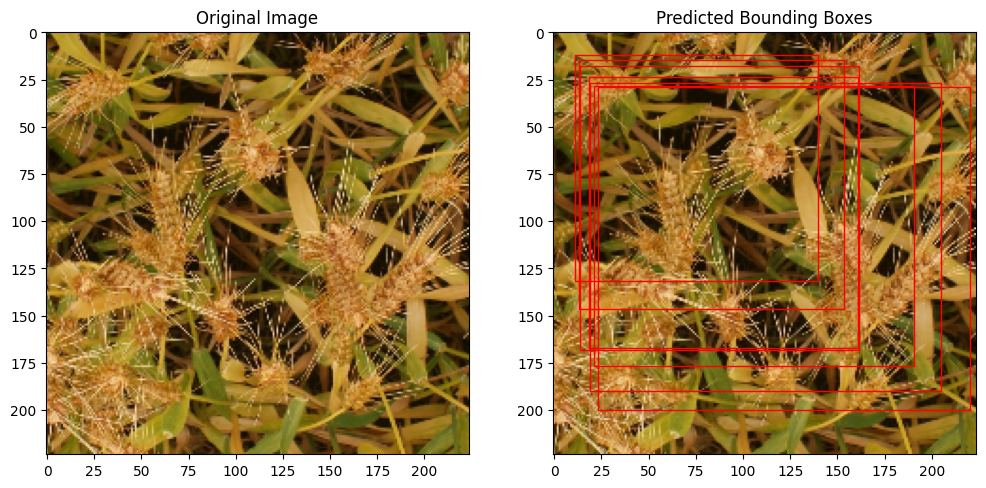

1/1 [==============================] - 0s 15ms/step


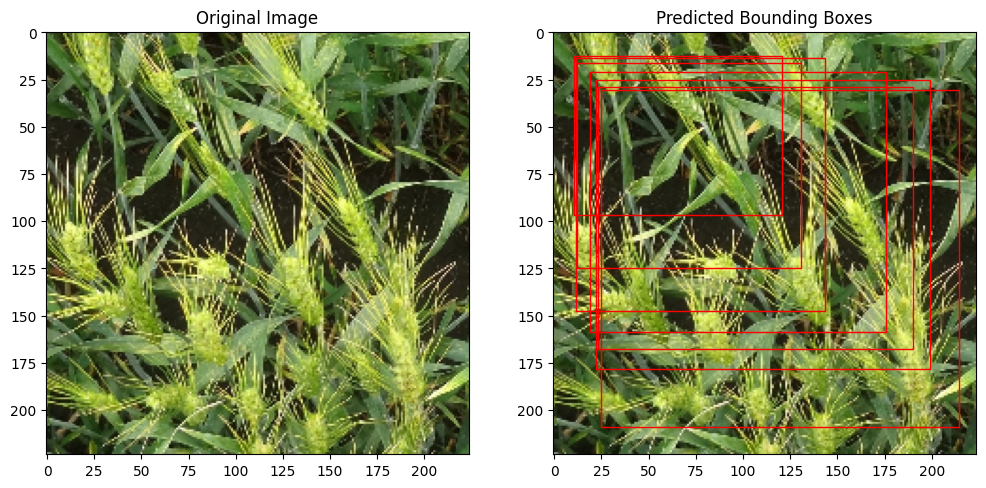

1/1 [==============================] - 0s 20ms/step


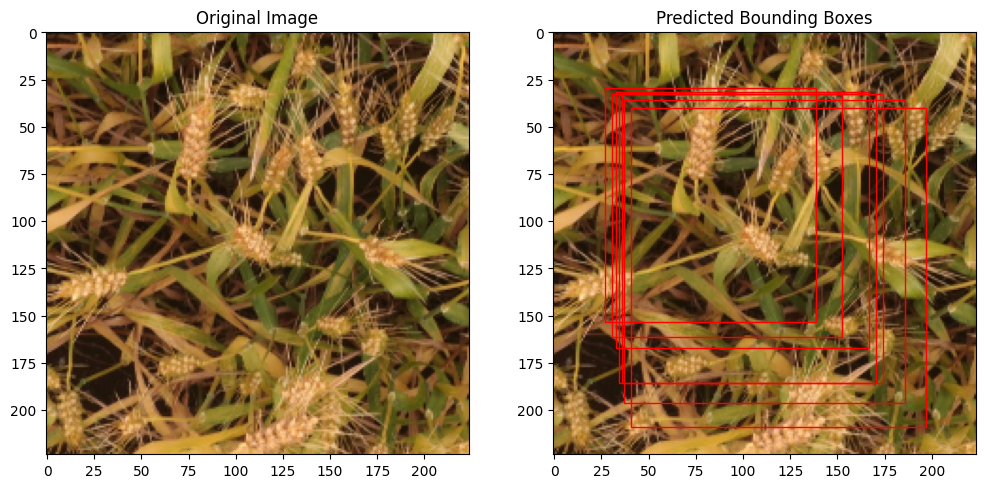

1/1 [==============================] - 0s 12ms/step


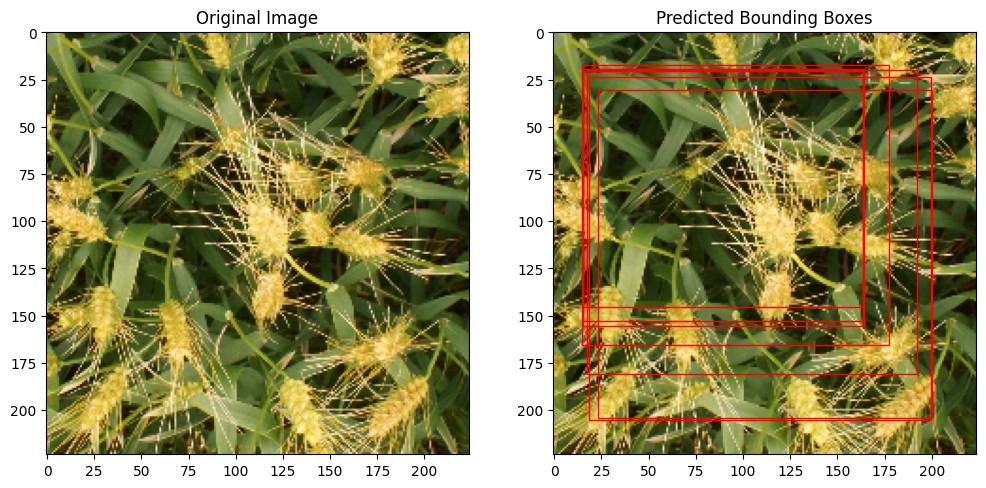

1/1 [==============================] - 0s 18ms/step


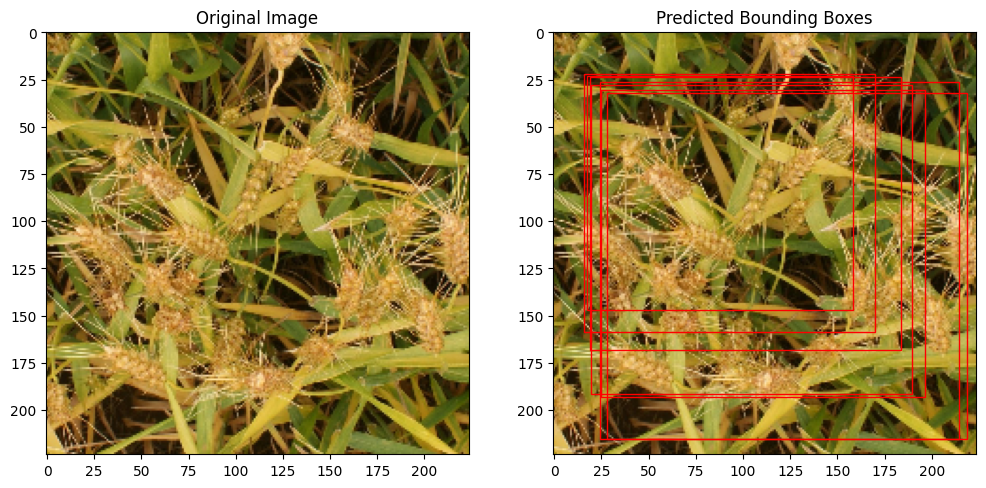

In [84]:
# Load and preprocess the image
def load_and_preprocess_image(image_path, IMG_SIZE=224):
    target_size = (IMG_SIZE, IMG_SIZE)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    
    image = tf.image.resize(image, target_size)
    image_array = np.array(image)
    image_array = image_array / 255.0  # Normalize the image
    
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    scale = tf.cast(original_size[0], tf.float32) / IMG_SIZE
    
    # Convert the image tensor to a NumPy array for display
    image_for_display = image.numpy() / 255.0
    
    return image_array, image_for_display, scale

# Function to get all .jpg files in a directory
def get_all_jpg_files_in_dir(directory):
    jpg_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    return jpg_files

# Example usage
directory = './global-wheat-detection/test'
all_jpg_files = get_all_jpg_files_in_dir(directory)

# Load the model
# model = tf.keras.models.load_model('path_to_your_model.h5')

# Example usage
# image_path = './global-wheat-detection/test/2fd875eaa.jpg'
for i in range(len(all_jpg_files)):
    image_path = all_jpg_files[i]
    image_array, image, scale = load_and_preprocess_image(image_path)
    bboxes = predict_bboxes(model, image)
    bboxes = bboxes * scale
    bboxes = filter_bboxes(bboxes, max_value=256)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')

    # Plot the bounding boxes
    plot_image_with_bboxes(axes[1], image, bboxes, num_plot=8)
    axes[1].set_title('Predicted Bounding Boxes')
    plt.show()

# OS

In [45]:
import os

# Path to your MP3 file
# mp3_file = r"C:\Users\WenShen\Documents\GitHub\That's Why I Like You.mp3"

# Use the os module to call Windows Media Player
# os.system(f'start wmplayer "{mp3_file}"')

- hyperparameter tuning and models path zip and send to me for compile